# Challenge: Model Comparison

Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

### Data Description

This data is from Szeged, Hunary between 2006 -2016. The goal is to build a regression model to predidct apparent Temperature.

In [1]:
#### Imports #######

#Basic
import pandas as pd
import numpy as np
import scipy

#Models
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

#Select K Best for feature Engineering
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#Split the data
from sklearn.model_selection import train_test_split

#Plot data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
##### Data Import ####
data = pd.read_csv('weatherHistory.csv')
data.head(1)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.


### Exploratory Data Analysis

In [102]:
#Using thee info to check datatypes and to see if there are any missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
Formatted Date              96453 non-null object
Summary                     96453 non-null object
Precip Type                 96453 non-null object
Temperature (C)             96453 non-null float64
Apparent Temperature (C)    96453 non-null float64
Humidity                    96453 non-null float64
Wind Speed (km/h)           96453 non-null float64
Wind Bearing (degrees)      96453 non-null float64
Visibility (km)             96453 non-null float64
Loud Cover                  96453 non-null float64
Pressure (millibars)        96453 non-null float64
Daily Summary               96453 non-null object
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
#Even though this variable has no missing values, there are still nulls
data['Precip Type'].value_counts()

rain    85224
snow    10712
null      517
Name: Precip Type, dtype: int64

In [6]:
#This gives a good description. Will use these as dummy variables.
data['Summary'].value_counts()

Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Windy and Mostly Cloudy                   35
Breezy and Foggy                          35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

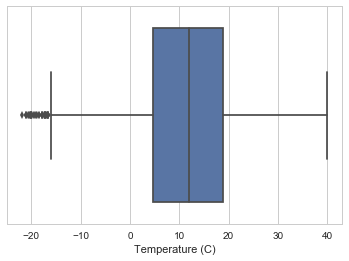

In [3]:
#Looking at the data to look at outliers. However, since its weather data, dont expect too much
sns.boxplot(data['Temperature (C)'])

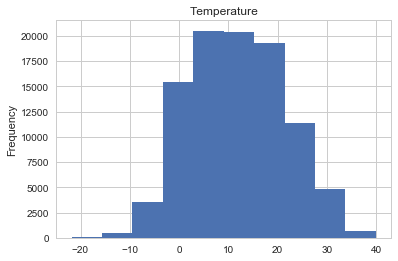

In [12]:
#Histogram to see if the data is normally distributed.
plt.figure()
data['Temperature (C)'].plot(kind='hist')
plt.title('Temperature')

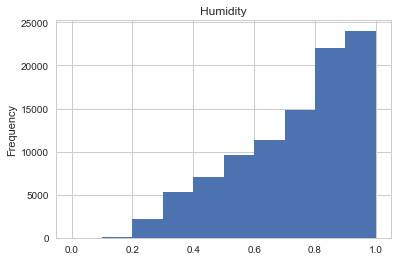

In [14]:
#Humidity is not normally distributed but skewed to the right.
plt.figure()
data['Humidity'].plot(kind='hist')
plt.title('Humidity')

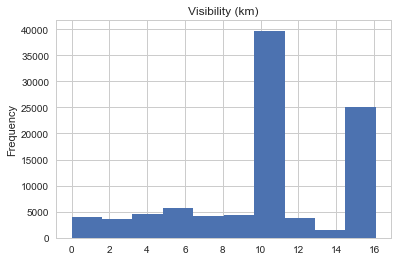

In [45]:
#Visibility is not normally distributed
plt.figure()
data['Visibility (km)'].plot(kind='hist')
plt.title('Visibility (km)')

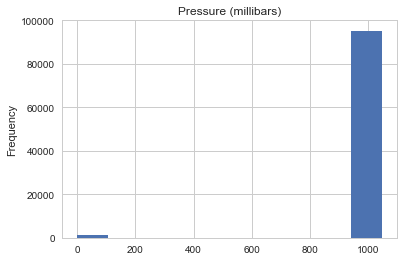

In [46]:
#Pressure is not distributed
plt.figure()
data['Pressure (millibars)'].plot(kind='hist')
plt.title('Pressure (millibars)')

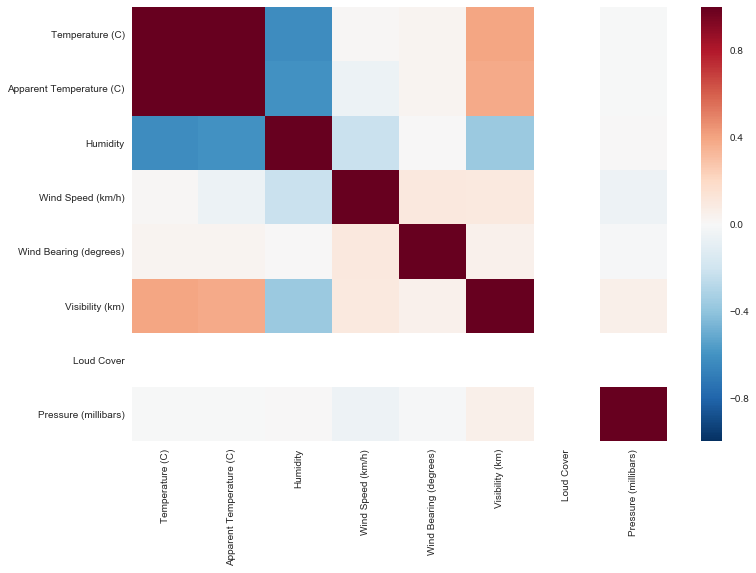

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr())

Apparent Temperature and Temperature are highly correlated. Im postulating that there are other factors that make the temperature "feel" a certain way, and the goal is to build a model to predict this.

### Feature Engineering

In [4]:
#Create dummy features
features = pd.get_dummies(data['Summary'])

In [5]:
#Add Continuous variables
features['Temperature (C)'] = data['Temperature (C)']
features['Humidity'] = data['Humidity']
features['Wind Speed (km/h)'] = data['Wind Speed (km/h)']
features['Visibility (km)'] = data['Visibility (km)']
features['Pressure (millibars)'] = data['Pressure (millibars)']

In [6]:
#Create outcome
outcome = data['Apparent Temperature (C)']

In [7]:
#Feature selection with k best
selector = SelectKBest(f_regression, k=15)
selector.fit(features,outcome)

idxs_selected = selector.get_support(indices=True)
features[features.columns[idxs_selected]].head(1)

,Breezy,Breezy and Foggy,Breezy and Overcast,Dry,Dry and Mostly Cloudy,Dry and Partly Cloudy,Foggy,Humid and Mostly Cloudy,Mostly Cloudy,Overcast,Partly Cloudy,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km)
0,0,0,0,0,0,0,0,0,0,0,1,9.472222,0.89,14.1197,15.8263


In [8]:
#Select best
features_best = features[features.columns[idxs_selected]]

#### Stats Model

In [9]:
#Create Features variables
breezy = features_best['Breezy']
breezy_and_foggy = features_best['Breezy and Foggy']
breezy_and_overcast = features_best['Breezy and Overcast']
dry = features_best['Dry']
dry_and_mostly_cloudy = features_best['Dry and Mostly Cloudy']
dry_and_partly_cloudy = features_best['Dry and Partly Cloudy']
foggy = features_best['Foggy']
humid_and_mostly_cloudy = features_best['Humid and Mostly Cloudy']
mostly_cloudy = features_best['Mostly Cloudy']
overcast = features_best['Overcast']
partly_cloudy = features_best['Partly Cloudy']
temperature = features_best['Temperature (C)']
humidity = features_best['Humidity']
wind_speed = features_best['Wind Speed (km/h)']
visibility = features_best['Visibility (km)']

In [10]:
#Stats Models
x = np.column_stack((breezy, breezy_and_foggy, breezy_and_overcast,
                     dry,dry_and_mostly_cloudy, dry_and_partly_cloudy, foggy, humidity, humid_and_mostly_cloudy,
                     mostly_cloudy,overcast,  partly_cloudy,temperature, humidity, wind_speed, visibility))
x = sm.add_constant(x, prepend=True)

results = smf.OLS(outcome,x).fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Apparent Temperature (C)   R-squared:                       0.990
Model:                                  OLS   Adj. R-squared:                  0.990
Method:                       Least Squares   F-statistic:                 6.294e+05
Date:                      Fri, 02 Mar 2018   Prob (F-statistic):               0.00
Time:                              20:29:42   Log-Likelihood:            -1.4390e+05
No. Observations:                     96453   AIC:                         2.878e+05
Df Residuals:                         96437   BIC:                         2.880e+05
Df Model:                                15                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

In [11]:
#Create new features based off of Stats models test. Remove all those with p value > 0.05
filtered_feat = pd.concat([breezy, 
breezy_and_foggy,
dry,
dry_and_mostly_cloudy,
dry_and_partly_cloudy,
foggy,
humidity, 
humid_and_mostly_cloudy,                     
partly_cloudy,
temperature, 
humidity, 
wind_speed, 
visibility], axis=1)

### Split the data for Validation

In [12]:
#Split the data
features_train, features_test, outcome_train, outcome_test = train_test_split(filtered_feat, outcome, test_size=0.30)

### OLS Regression

In [14]:
from sklearn.grid_search import GridSearchCV

# Instantiate and fit our model.
regr = linear_model.LinearRegression()

parameters = {'normalize':[True,False]}

#Note for regression problems have to do different scoreing methods:
grid = GridSearchCV(regr, parameters, scoring='r2', cv=5, verbose=0)


#Fit the Data
grid.fit(features_train, outcome_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': [True, False]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='r2', verbose=0)

In [15]:
grid.best_score_

0.9898735414182922

In [26]:
#Test Data with validation holdout
#Inspect the results.
print('\nCoefficients: \n', grid.best_estimator_.coef_)
print('\nIntercept: \n', grid.best_estimator_.intercept_)
print('\nR-squared:')
print(grid.score(features_test, outcome_test))


Coefficients: 
 [-0.69840027 -2.09500915 -1.20337277 -0.74594851 -0.68526744  0.25616729
  0.4913065  -0.14834945 -0.07085092  1.12639706  0.4913065  -0.09429476
  0.00945141]

Intercept: 
 -2.38099871272

R-squared:
0.989861641018


/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Tried a lot of things, from selecting the best features, cross validation, and the best score I was able to get was 0.43 without Temperature and with Temperature its 0.9899

### Feature Engineering for KNN

In [127]:
#Since cant use categorical, will only be using the continuous variables.
#Add Continuous variables
features = data[['Temperature (C)','Humidity','Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']]

In [128]:
#Create outcome
outcome = data['Apparent Temperature (C)']

In [129]:
#Create validation holdout
features_train, features_test, outcome_train, outcome_test = train_test_split(features, outcome, test_size=0.30)

In [130]:
from scipy import stats
#Normalize Features
X = pd.DataFrame({
    'humidity': stats.zscore(features_train['Humidity']),
    'wind_speed': stats.zscore(features_train['Wind Speed (km/h)']),
    'visibility': stats.zscore(features_train['Visibility (km)']),
    'pressure': stats.zscore(features_train['Pressure (millibars)']),
    'temperature': stats.zscore(features_train['Temperature (C)'])
})




In [131]:
#Call KNN
knn = neighbors.KNeighborsRegressor()

parameters = {
    'n_neighbors':[2,5,10,15,20],
    'weights':['uniform','distance']    
}

grid = GridSearchCV(knn, parameters, scoring='r2', cv=5, verbose=0)
#Fit the Data
grid.fit(X, outcome_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 5, 10, 15, 20], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [132]:
grid.best_score_

0.9971833748859573

In [126]:
grid.best_params_

{'n_neighbors': 20, 'weights': 'distance'}

### Write Up

Played around with the features with and without Temperature. Withot Temp the Linear regression model was 0.43 and the KNN was 0.56. When the temp was added the KNN went to 0.997, and Linear Regression went to 0.9897